# Load libraries

In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

# Load Data

In [2]:
# df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQMaaNO_0JU-A2gdSyJpF-WEjJGqWqZdIIp9g9gHGpTdJ3G8l6BvV1PvtmrB3nUTHxnDC_zbiAp3sJx/pub?gid=353977511&single=true&output=csv")
# df.rename(columns={'Unnamed: 0': 'id', "_comments_ASR_unfiltered": "ASR"}, inplace=True)
# df = df[['id', 'label', 'captions', 'ASR']]
# exclude_id  =[60580, 80644, 80662, 80670, 80685, 80716, 114392, 114403, 114409, 114410]
# df = df[~df['id'].isin(exclude_id)]
# df = df[df['label'].isin(['Shots on target', 'Shots off target', 'Foul', 'Corner', 'Throw-in'])]
# df.head()

,id,label,captions,ASR
0,36,Shots on target,Player hears the fans clapping his superb goal...,Chelsea has recovered again in the final third...
1,44,Corner,Corner kick. Player (Away-Team) is ready to se...,Tripper. Ready to strike. There goes Trippier'...
2,57,Shots off target,A cross by Player (Home-Team) from the side of...,There's Hazard. Hazard made a good move toward...
3,74,Throw-in,Player (Home-Team) takes a first-time shot fro...,Diego Costa anticipates. Jones can score. It e...
7,160,Shots on target,"Player (Home-Team) picks up a pass, lines up a...","He wants those races, even if it's towards the..."


# Data Preprocessing
## Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['id'].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label'])
id2label = dict(enumerate(df['label'].unique()))
label2id = {v: k for k, v in id2label.items()}
num_classes = len(id2label)

## Data Loader

In [92]:
ASR_dict = {idx: asr for asr,idx in zip(*torch.load("/content/ASR.pt"))}
captions_dict = {idx: asr for asr,idx in zip(*torch.load("/content/captions.pt"))}
audio_dict = {idx: asr for asr,idx in zip(*torch.load("/content/audios.pt"))}
# audio_dict = {key: torch.randn(512) for key in ASR_dict.keys()}


class CustomDataset(Dataset):
    def __init__(self, game_idx, labels,):
        self.game_idx = list(game_idx)
        self.label = list(labels)
        # assert all game_idx in ASR_dict
        assert [e in ASR_dict for e in self.game_idx]

    def __getitem__(self, index):
        current_tokens = self.game_idx[index]
        current_label = self.label[index]

        x = current_tokens
        y = label2id[current_label]
        return x, y

    def __len__(self):
        return len(self.game_idx)


class CollateFunctor:
    def __call__(self, samples):
        input_ids = [x for x, _ in samples]
        labels = [y for _, y in samples]
        ASRs = [ASR_dict[x].numpy() for x in input_ids]
        captions = [captions_dict[x].numpy() for x in input_ids]
        audios = [audio_dict[x].numpy() for x in input_ids]
        return torch.tensor(ASRs), torch.tensor(captions), torch.tensor(audios), torch.tensor(labels)

# Model

In [132]:
create_sub_model = lambda input_type, feature_dim, hidden_dim, dropout_p: nn.Sequential(
    nn.Linear(feature_dim, hidden_dim),
    nn.ReLU(),
    nn.Dropout(p=dropout_p)
)

feature_dims = { 'asr': 384,   'captions': 384,  'audio': 512}

class ClassificationModel(nn.Module):
    def __init__(self, hidden_dims, dropout_p=0.5):
        super().__init__()
        self.models = nn.ModuleDict({
            feature: create_sub_model(feature, feature_dims[feature], hidden_dims[feature], dropout_p)
            for feature, vector_len in hidden_dims.items() if vector_len
        })

        total_features = sum(hidden_dims[feature] for feature in self.models.keys())
        self.classifier = nn.Linear(total_features, num_classes)

    def forward(self, **inputs):
        features = [self.models[feature](inputs[feature]) for feature in inputs if feature in self.models]
        concatenated_features = torch.cat(features, dim=1)
        return self.classifier(concatenated_features)

# model = ClassificationModel(hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}, dropout_p=0.5)
# model

# Training loop

In [133]:
def train(model, criterion, _optimizer, train_loader, val_loader, epochs, verbose):
    model.to(device)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for asrs, captions, audios, labels in train_loader:
            _optimizer.zero_grad()
            outputs = model(asr=asrs, captions=captions, audio=audios)
            loss = criterion(outputs, labels)
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for asrs, captions, audios, labels in val_loader:
                outputs = model(asr=asrs, captions=captions, audio=audios)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        val_loss.append(running_loss / len(val_loader))
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
        if verbose:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.6f}, Val. Loss: {val_loss[-1]:.6f}, F1: {f1:.6f}')
                        # Precision: {precision:.6f}, Recall: {recall:.6f},
        else:
            print(f'{f1*100:.2f},', end=" ")
    print("")
    return train_loss, val_loss

# Evaluation and Plotting

In [134]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs =[]
    with torch.no_grad():
        for asrs, captions, audios, labels in data_loader:
            outputs = model(asr=asrs, captions=captions, audio=audios)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.numpy())

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values()), zero_division=0))
    return all_outputs, all_labels

def plot_loss_curve(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Helper function for training and evaluation

In [135]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_evaluate(hidden_dims, dropout_p, lr_, epochs_, batch_size_, verbose_=True):
    model = ClassificationModel(hidden_dims=hidden_dims, dropout_p=dropout_p).to(device)
    if verbose_:
      print(model)
      print("Trainable paramaters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
      print(f"Hidden_dims:  {hidden_dims}, batch_size: {batch_size_}, lr: {lr_}, dropout_p: {dropout_p}")

    train_loader = DataLoader(CustomDataset(X_train, y_train), batch_size=batch_size_, shuffle=True, collate_fn=CollateFunctor())
    test_loader = DataLoader(CustomDataset(X_test, y_test), batch_size=batch_size_, shuffle=False, collate_fn=CollateFunctor())

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_)

    train_loss, val_loss = train(model, criterion, optimizer, train_loader, test_loader, epochs=epochs_, verbose=verbose_)
    outputs_, all_labels_ = evaluate(model, test_loader)

    return model, train_loss, val_loss, (outputs_, all_labels_)

# Experiments

## Experiment A-1: Captions and ASR

ClassificationModel(
  (models): ModuleDict(
    (captions): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (audio): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=256, out_features=5, bias=True)
)
Trainable paramaters:  116229
Hidden_dims:  {'asr': False, 'captions': 128, 'audio': 128}, batch_size: 128, lr: 0.0005, dropout_p: 0.5
Epoch 1, Train Loss: 1.535174, Val. Loss: 1.473628, F1: 0.254186
Epoch 2, Train Loss: 1.419124, Val. Loss: 1.324003, F1: 0.424270
Epoch 3, Train Loss: 1.272826, Val. Loss: 1.168661, F1: 0.532879
Epoch 4, Train Loss: 1.148269, Val. Loss: 1.066929, F1: 0.544681
Epoch 5, Train Loss: 1.080098, Val. Loss: 1.002215, F1: 0.583442
Epoch 6, Train Loss: 1.030024, Val. Loss: 0.959868, F1: 0.593595
Epoch 7, Train Loss: 0.991789, Val. Loss: 0.92

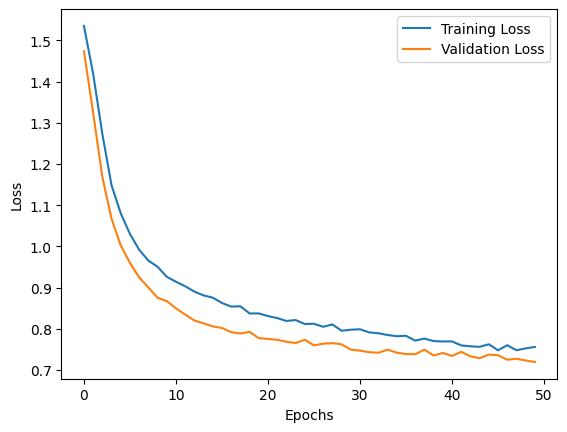

In [136]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_, train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': False, 'captions': 128, 'audio': 128},
                                          dropout_p=0.5, lr_=0.0005, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment A-1: Audio and ASR

ClassificationModel(
  (models): ModuleDict(
    (asr): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (audio): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=256, out_features=5, bias=True)
)
Trainable paramaters:  116229
Hidden_dims:  {'asr': 128, 'captions': False, 'audio': 128}, batch_size: 128, lr: 0.0005, dropout_p: 0.5
Epoch 1, Train Loss: 1.562715, Val. Loss: 1.539213, F1: 0.190639
Epoch 2, Train Loss: 1.531058, Val. Loss: 1.512256, F1: 0.163447
Epoch 3, Train Loss: 1.502090, Val. Loss: 1.482763, F1: 0.212198
Epoch 4, Train Loss: 1.471350, Val. Loss: 1.444351, F1: 0.215617
Epoch 5, Train Loss: 1.438489, Val. Loss: 1.405777, F1: 0.251600
Epoch 6, Train Loss: 1.403803, Val. Loss: 1.367825, F1: 0.288344
Epoch 7, Train Loss: 1.375132, Val. Loss: 1.338057,

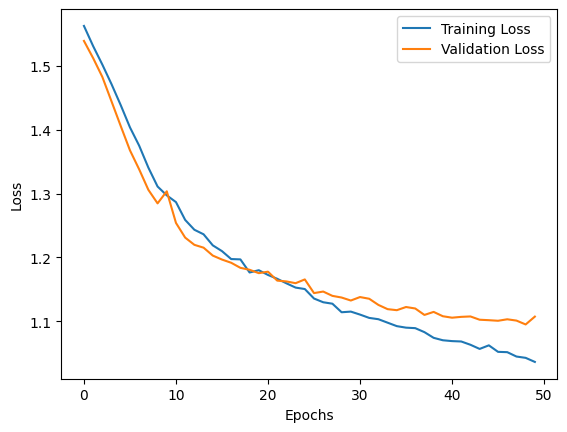

In [104]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_, train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': 128, 'captions': False, 'audio': 128},
                                          dropout_p=0.5, lr_=0.0005, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment A-3: Captions and ASR

ClassificationModel(
  (models): ModuleDict(
    (asr): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (captions): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=256, out_features=5, bias=True)
)
Trainable paramaters:  99845
Hidden_dims:  {'asr': 128, 'captions': 128, 'audio': False}, batch_size: 128, lr: 0.0005, dropout_p: 0.5
Epoch 1, Train Loss: 1.542905, Val. Loss: 1.496365, F1: 0.188443
Epoch 2, Train Loss: 1.441500, Val. Loss: 1.374308, F1: 0.472236
Epoch 3, Train Loss: 1.310950, Val. Loss: 1.231835, F1: 0.508694
Epoch 4, Train Loss: 1.195679, Val. Loss: 1.129680, F1: 0.532534
Epoch 5, Train Loss: 1.123032, Val. Loss: 1.067463, F1: 0.542286
Epoch 6, Train Loss: 1.078264, Val. Loss: 1.028520, F1: 0.555330
Epoch 7, Train Loss: 1.048709, Val. Loss: 0.99757

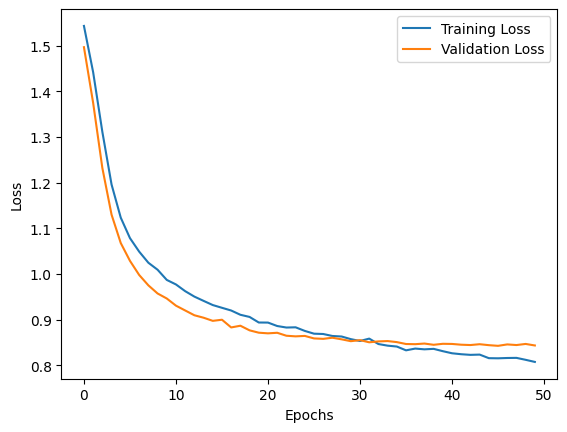

In [105]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_, train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': 128, 'captions': 128, 'audio': False},
                                          dropout_p=0.5, lr_=0.0005, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment B: ASR, Captions, and Audio

ClassificationModel(
  (models): ModuleDict(
    (asr): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (captions): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (audio): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=384, out_features=5, bias=True)
)
Trainable paramaters:  166149
Hidden_dims:  {'asr': 128, 'captions': 128, 'audio': 128}, batch_size: 128, lr: 0.0005, dropout_p: 0.5
Epoch 1, Train Loss: 1.527440, Val. Loss: 1.469731, F1: 0.220884
Epoch 2, Train Loss: 1.408700, Val. Loss: 1.310806, F1: 0.477255
Epoch 3, Train Loss: 1.252892, Val. Loss: 1.154670, F1: 0.498086
Epoch 4, Train Loss: 1.131370, Val. Loss: 1.051901, F1: 0.548533
Epoch 5, Train Loss: 1.059

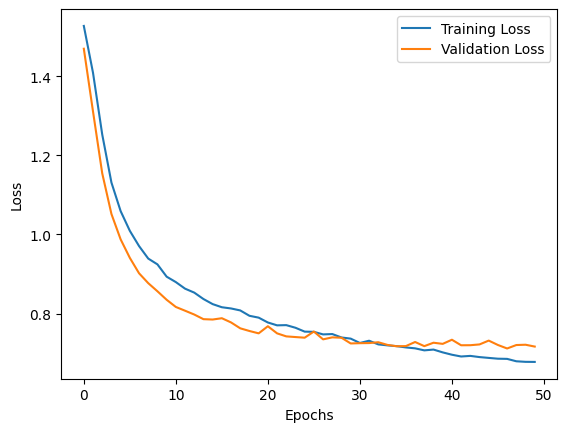

In [122]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
model_f, train_loss_, val_loss_, val_return_f = train_evaluate(hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128},
                                          dropout_p=0.5, lr_=0.0005, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment C-1: ASR only

ClassificationModel(
  (models): ModuleDict(
    (asr): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)
Trainable paramaters:  49925
Hidden_dims:  {'asr': 128, 'captions': None, 'audio': None}, batch_size: 128, lr: 0.001, dropout_p: 0.5
Epoch 1, Train Loss: 1.562646, Val. Loss: 1.550041, F1: 0.088154
Epoch 2, Train Loss: 1.541373, Val. Loss: 1.534167, F1: 0.129576
Epoch 3, Train Loss: 1.521916, Val. Loss: 1.512653, F1: 0.210925
Epoch 4, Train Loss: 1.496980, Val. Loss: 1.490599, F1: 0.210842
Epoch 5, Train Loss: 1.474369, Val. Loss: 1.470097, F1: 0.246264
Epoch 6, Train Loss: 1.454455, Val. Loss: 1.451478, F1: 0.247476
Epoch 7, Train Loss: 1.438818, Val. Loss: 1.439020, F1: 0.253089
Epoch 8, Train Loss: 1.423832, Val. Loss: 1.428325, F1: 0.266757
Epoch 9, Train Loss: 1.415049, Val. Loss: 1.421448, F1: 0.286901
Epoch 10, Tr

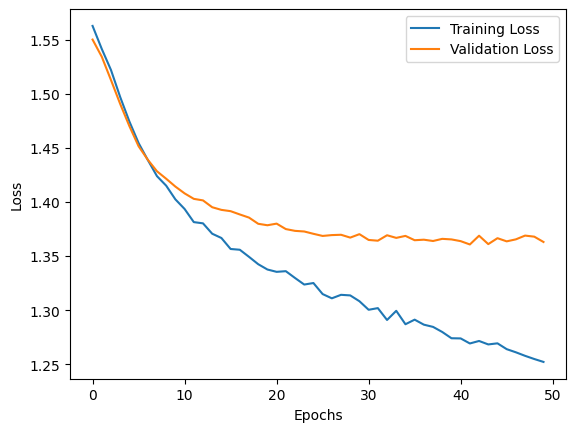

In [121]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_, train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': 128, 'captions': None, 'audio': None},
                                          dropout_p=0.5, lr_=0.001, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment C-2: Captions only

ClassificationModel(
  (models): ModuleDict(
    (captions): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)
Trainable paramaters:  49925
Hidden_dims:  {'asr': None, 'captions': 128, 'audio': None}, batch_size: 128, lr: 0.0005, dropout_p: 0.5
Epoch 1, Train Loss: 1.546126, Val. Loss: 1.491229, F1: 0.278739
Epoch 2, Train Loss: 1.442074, Val. Loss: 1.379786, F1: 0.392683
Epoch 3, Train Loss: 1.330251, Val. Loss: 1.256293, F1: 0.463674
Epoch 4, Train Loss: 1.228850, Val. Loss: 1.162355, F1: 0.527903
Epoch 5, Train Loss: 1.161035, Val. Loss: 1.100309, F1: 0.543301
Epoch 6, Train Loss: 1.117471, Val. Loss: 1.060581, F1: 0.551984
Epoch 7, Train Loss: 1.084330, Val. Loss: 1.028787, F1: 0.565365
Epoch 8, Train Loss: 1.058908, Val. Loss: 1.006154, F1: 0.565744
Epoch 9, Train Loss: 1.043688, Val. Loss: 0.989316, F1: 0.565636
Epoch 

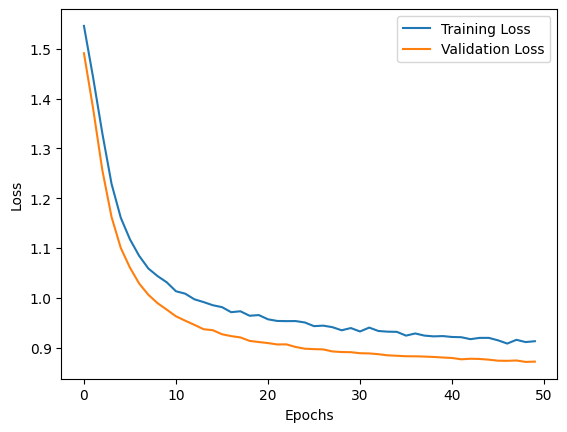

In [120]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_, train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': None, 'captions': 128, 'audio': None},
                                          dropout_p=0.5, lr_=0.0005, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

## Experiment C-3: Audio only

ClassificationModel(
  (models): ModuleDict(
    (audio): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)
Trainable paramaters:  66309
Hidden_dims:  {'asr': None, 'captions': None, 'audio': 128}, batch_size: 128, lr: 0.001, dropout_p: 0.5
Epoch 1, Train Loss: 1.556674, Val. Loss: 1.520676, F1: 0.169575
Epoch 2, Train Loss: 1.518083, Val. Loss: 1.486522, F1: 0.189087
Epoch 3, Train Loss: 1.482872, Val. Loss: 1.442842, F1: 0.237061
Epoch 4, Train Loss: 1.450773, Val. Loss: 1.407889, F1: 0.202675
Epoch 5, Train Loss: 1.424318, Val. Loss: 1.378686, F1: 0.226612
Epoch 6, Train Loss: 1.406206, Val. Loss: 1.358418, F1: 0.255406
Epoch 7, Train Loss: 1.391817, Val. Loss: 1.350588, F1: 0.256903
Epoch 8, Train Loss: 1.377765, Val. Loss: 1.337227, F1: 0.265010
Epoch 9, Train Loss: 1.358118, Val. Loss: 1.327954, F1: 0.306672
Epoch 10, 

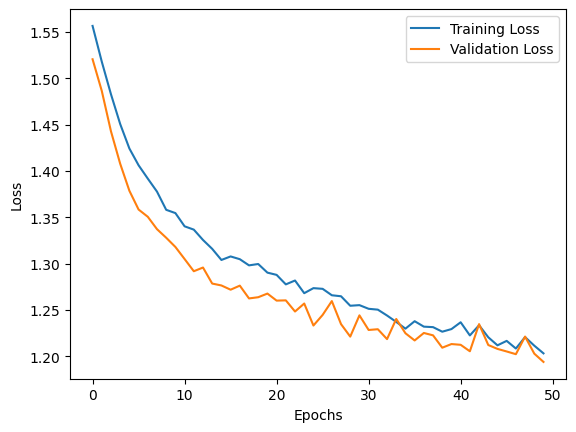

In [119]:
# hidden_dims= { 'asr': 128, 'captions': 128, 'audio': 128}
_ , train_loss_, val_loss_, val_return = train_evaluate(hidden_dims= { 'asr': None, 'captions': None, 'audio': 128},
                                          dropout_p=0.5, lr_=0.001, epochs_=50, batch_size_=128, verbose_=True)
plot_loss_curve(train_loss_, val_loss_)

# Best model plotting

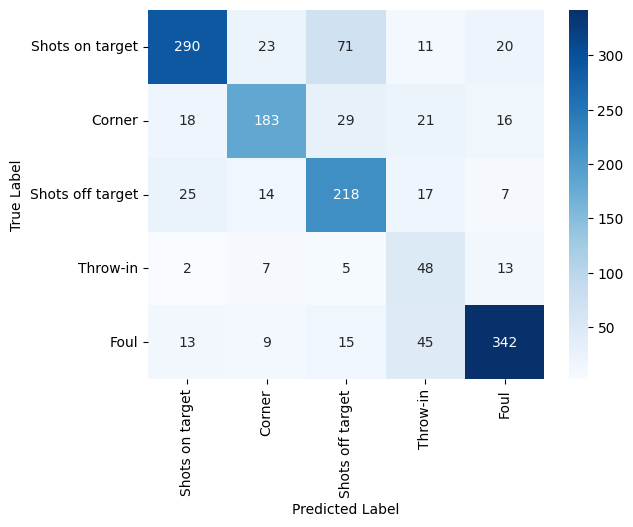

In [123]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

outputs__, all_targets= val_return_f
all_preds = np.argmax(outputs__, axis=1)
conf_matrix = confusion_matrix(all_preds, all_targets)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id, yticklabels=label2id)
# plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Receiver operating characteristic for multi-class


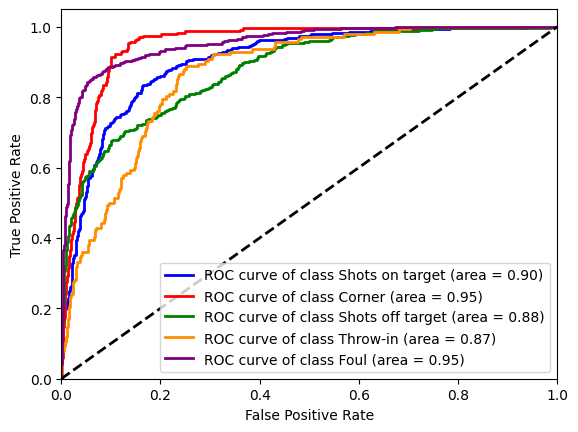

In [124]:
y_score= np.array(outputs__)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(id2label)

y_test_one_hot = np.eye(n_classes)[[label2id[i] for i in y_test]]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'darkorange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(id2label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


Multi-Class Precision-Recall Curve


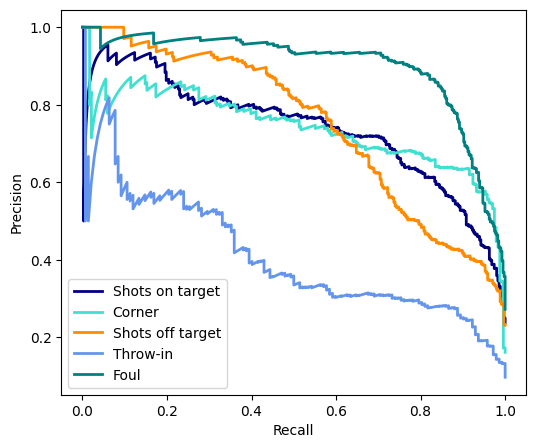

In [125]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize([label2id[i] for i in y_test], classes=range(n_classes))

precision_recall = {}

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    precision_recall[i] = (precision, recall)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(6, 5))

for i, color in zip(range(n_classes), colors):
    precision, recall = precision_recall[i]
    plt.plot(recall, precision, color=color, lw=2, label=f'{id2label[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
print('Multi-Class Precision-Recall Curve')
plt.legend(loc='best')
plt.show()